<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_new_ConvTwist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet with a Twist

> ConvTwist + Mish + MaxBlurPool + restrick

# setup and imports

In [2]:
!pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-5mwa6jui
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-5mwa6jui
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=c1404d86ff6079a5fe9c1fcdd49d062fcf390155c829d4d31add1461bb776298
  Stored in directory: /tmp/pip-ephem-wheel-cache-q49qkwnr/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [3]:
!pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-l33hd9xf
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-l33hd9xf
     |████████████████████████████████| 143kB 5.9MB/s 
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=bf44f2a2d05d32fbfd657bdb95d4869bd1dd7b5ea2c07027071fd4c3cae56f0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-eo3jgtn7/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import Net, act_fn
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, init=0.7, iters=2):
        super(ConvTwist, self).__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.grad_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]])
        self.grad_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]])
        std = self.conv.weight.std().item()
        self.coeff_x = nn.Parameter(torch.empty((nf,ni)).normal_(0, std), requires_grad=True)
        self.coeff_y = nn.Parameter(torch.empty((nf,ni)).normal_(0, std), requires_grad=True)
        self.center_x = nn.Parameter(torch.empty(nf).normal_(0, init), requires_grad=False)
        self.center_y = nn.Parameter(torch.empty(nf).normal_(0, init), requires_grad=False)
        # self.center_x = nn.Parameter(torch.empty((ni,nf)).normal_(0, init), requires_grad=False)
        # self.center_y = nn.Parameter(torch.empty((ni,nf)).normal_(0, init), requires_grad=False)
        self.same = ni == nf and stride == 1 and iters > 1
        self.iters = iters
        self.ni = ni
        self.stride = stride

    def forward(self, inpt):
        out = self.conv(inpt)
        _, _, h, w = out.size()
        XX = torch.from_numpy(np.indices((1,1,h,w))[3]*2/w-1).type(out.dtype).to(out.device) 
        YY = torch.from_numpy(np.indices((1,1,h,w))[2]*2/h-1).type(out.dtype).to(out.device)
        kernel_x = self.coeff_x[:,:,None,None] * self.grad_x.to(out.device) + self.coeff_y[:,:,None,None] * self.grad_y.to(out.device) 
        kernel_y = kernel_x.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        out = out + (XX-self.center_x[:,None,None]) * F.conv2d(inpt, kernel_x, stride=self.stride, padding=1) + (YY-self.center_y[:,None,None]) * F.conv2d(inpt, kernel_y, stride=self.stride, padding=1)
        # for i in range(self.ni-1):
        #     out += (XX-self.center_x[i,:,None,None]) * F.conv2d(inpt[:,i:i+1], kernel_x[:,i:i+1], padding=1) + (YY-self.center_y[i,:,None,None]) * F.conv2d(inpt[:,i:i+1], kernel_y[:,i:i+1], padding=1)
        if self.same:
            out = inpt + out / self.iters
            for _ in range(self.iters - 1):
                out = out + (self.conv(out) + (XX-self.center_x[:,None,None]) * F.conv2d(out, kernel_x, padding=1) + (YY-self.center_y[:,None,None]) * F.conv2d(out, kernel_y, padding=1)) / self.iters
            out = out - inpt
        return out

In [0]:
net = ConvTwist(3,5)
# for name, param in net.named_parameters():
#     print(name, param)
print(net.coeff_x.size())

A = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]) / 2
B = net.coeff_x[:,:,None,None] * A
print(B.size())

torch.Size([3, 5])
torch.Size([3, 5, 3, 3])


# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
        if ks==3:  layers = [('ConvTwist', ConvTwist(ni, nf, stride=stride))]
        else: layers = [('Conv{}x{}'.format(ks,ks), 
                  nn.Conv2d(ni, nf, ks, stride=stride, padding=padding, bias=bias, groups=groups))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1,
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False, sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0", conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nh, 3, act_fn=act_fn, bn_1st=bn_1st)), #!!!
                   (f"conv_2", conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x):
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

In [20]:
# hide
NewResBlock(4, 64, 128)

NewResBlock(
  (convs): Sequential(
    (conv_0): NewLayer(
      (Conv1x1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU(inplace=True)
    )
    (conv_1): NewLayer(
      (ConvTwist): ConvTwist(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU(inplace=True)
    )
    (conv_2): NewLayer(
      (Conv1x1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): NewLayer(
    (Conv1x1): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (merge): ReLU(inplace=True)

# Model Constructor

In [0]:
pool = MaxBlurPool2d(3, True)

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)

In [0]:
model.block = NewResBlock
model.conv_layer = NewLayer
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn = Mish()
model.sa = True

# runs



In [96]:
learn = get_learn(model=model, size=128, bs=32, mixup=0.5)
learn.fit_fc(80, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.073303,1.803838,0.429371,0.874523,02:10
1,1.938294,1.657154,0.490965,0.900229,02:09
2,1.791494,1.467634,0.571138,0.938916,02:09
3,1.717916,1.342679,0.640366,0.947060,02:09
4,1.670815,1.322562,0.655892,0.952405,02:09
5,1.607349,1.235953,0.695597,0.957496,02:09
6,1.565320,1.153179,0.740137,0.967676,02:09
7,1.529661,1.147111,0.739119,0.964877,02:09
8,1.504889,1.138240,0.729193,0.964368,02:09
9,1.480993,1.076234,0.765080,0.969458,02:08


In [85]:
for name, param in learn.model.stem.named_parameters():
    if 'center' in name:
        print(name, param.size(), param.mean().item(), param.std().item())

conv_0.ConvTwist.center_x torch.Size([32]) 0.021804530173540115 1.0876741409301758
conv_0.ConvTwist.center_y torch.Size([32]) -0.2153802514076233 0.8769471049308777
conv_1.ConvTwist.center_x torch.Size([64]) -0.10476788133382797 0.7495046257972717
conv_1.ConvTwist.center_y torch.Size([64]) -0.10684575140476227 0.7607750296592712
conv_2.ConvTwist.center_x torch.Size([64]) -0.02895568124949932 0.5663319230079651
conv_2.ConvTwist.center_y torch.Size([64]) -0.06732521951198578 0.6281421780586243


# with iterations and MaxBlurPool

`iters=3`

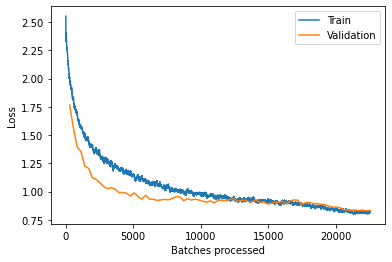

In [94]:
learn.recorder.plot_losses()

In [87]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.42784422636032104
epoch 1 0.5245609283447266
epoch 2 0.5645202398300171
epoch 3 0.6513107419013977
epoch 4 0.6935607194900513
epoch 5 0.7126495242118835
epoch 6 0.7424281239509583
epoch 7 0.7589717507362366
epoch 8 0.7615169286727905
epoch 9 0.7767879962921143
epoch 10 0.7582082152366638
epoch 11 0.7813693284988403
epoch 12 0.7902774214744568
epoch 13 0.8012216687202454
epoch 14 0.8114023804664612
epoch 15 0.8108933568000793
epoch 16 0.8096207976341248
epoch 17 0.814456582069397
epoch 18 0.8185288906097412
epoch 19 0.8203105330467224
epoch 20 0.8210740685462952
epoch 21 0.8083481788635254
epoch 22 0.8284550905227661
epoch 23 0.8124204874038696
epoch 24 0.8292186260223389
epoch 25 0.8365996479988098
epoch 26 0.8332909345626831
epoch 27 0.82387375831604
epoch 28 0.8182743787765503
epoch 29 0.8292186260223389
epoch 30 0.8317638039588928
epoch 31 0.824128270149231
epoch 32 0.831254780292511
epoch 33 0.8302366733551025
epoch 34 0.8302366733551025
epoch 35 0.8411809802055359
epoch 

In [50]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.ConvTwist.center_x 0.10916583985090256 0.6143451929092407
l_0.bl_0.convs.conv_1.ConvTwist.center_y -0.042716044932603836 0.8164669871330261
l_0.bl_1.convs.conv_1.ConvTwist.center_x -0.022748513147234917 0.6722005605697632
l_0.bl_1.convs.conv_1.ConvTwist.center_y 0.12624973058700562 0.6007344126701355
l_0.bl_2.convs.conv_1.ConvTwist.center_x 0.0905994176864624 0.6219170093536377
l_0.bl_2.convs.conv_1.ConvTwist.center_y 0.06449635326862335 0.7636317014694214
l_1.bl_0.convs.conv_1.ConvTwist.center_x 0.03629609942436218 0.6630207300186157
l_1.bl_0.convs.conv_1.ConvTwist.center_y 0.004368479363620281 0.6878974437713623
l_1.bl_1.convs.conv_1.ConvTwist.center_x -0.05933796986937523 0.7561393976211548
l_1.bl_1.convs.conv_1.ConvTwist.center_y 0.007083745673298836 0.6771031022071838
l_1.bl_2.convs.conv_1.ConvTwist.center_x 0.014617637731134892 0.6355658173561096
l_1.bl_2.convs.conv_1.ConvTwist.center_y 0.014518368989229202 0.716107964515686
l_1.bl_3.convs.conv_1.ConvTwist.c

Plotting the "centers" at the end of training — supposedly these are the points around which the `ConvTwist` is making a tiny rotation or dilation. I don't know what to make of these.

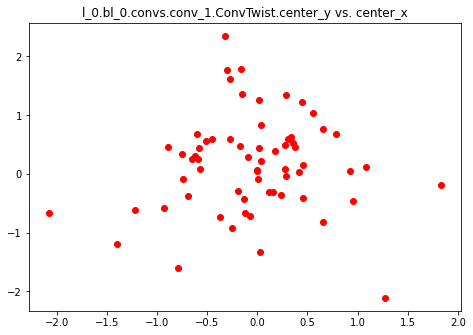

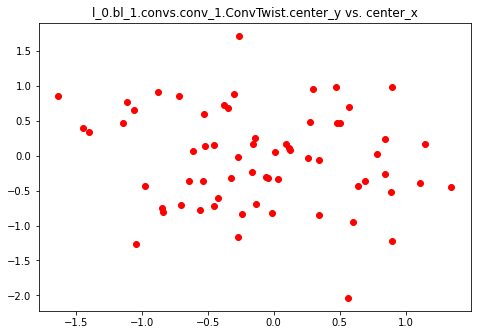

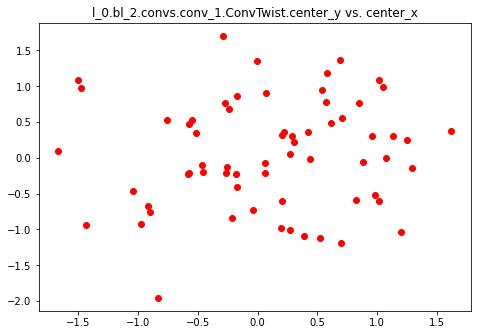

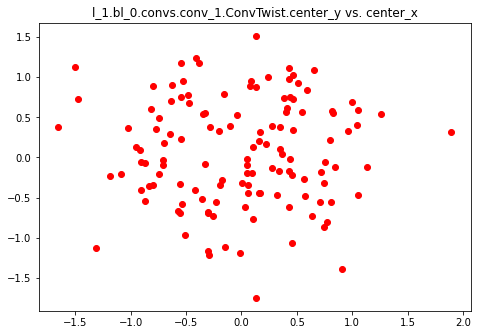

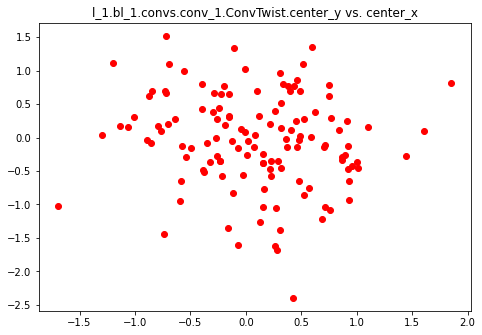

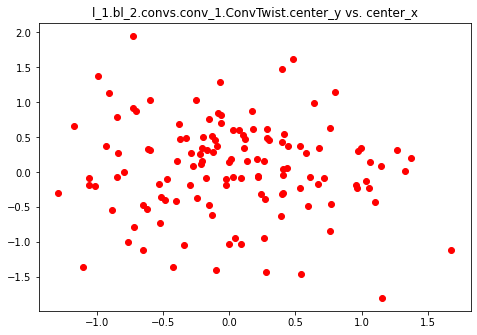

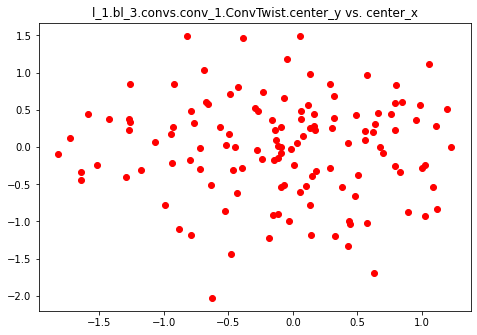

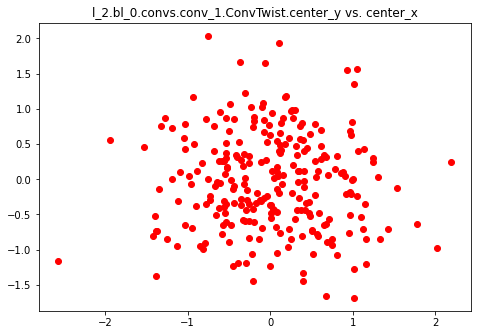

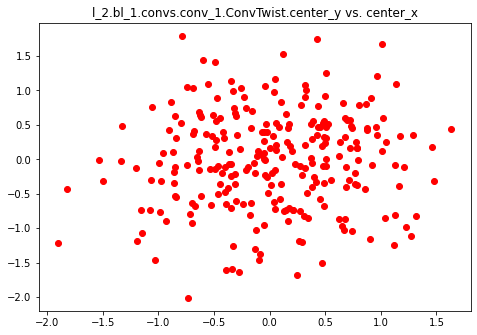

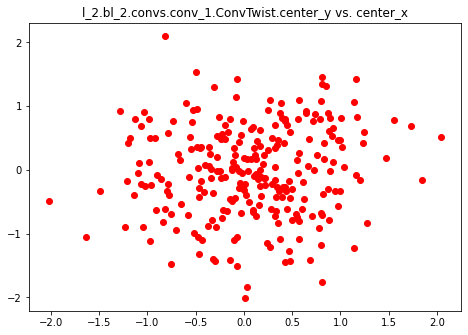

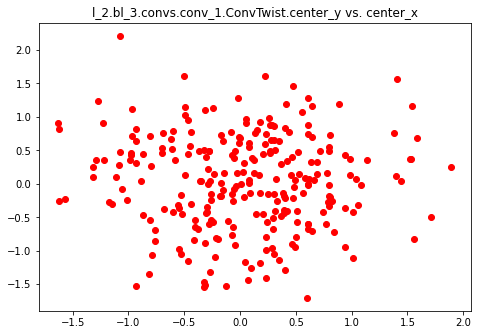

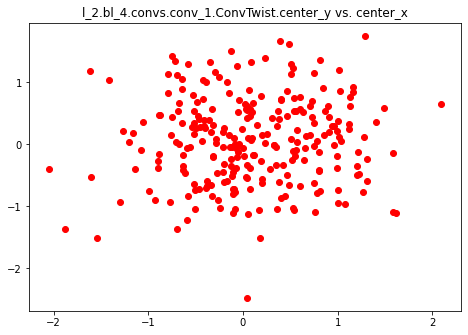

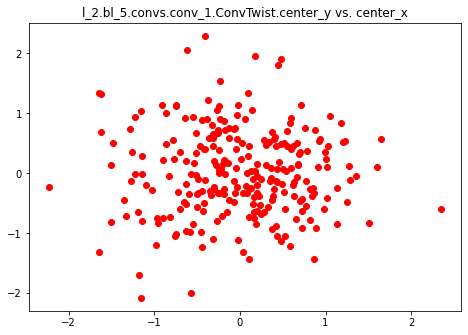

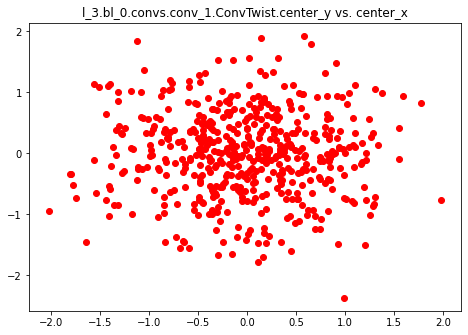

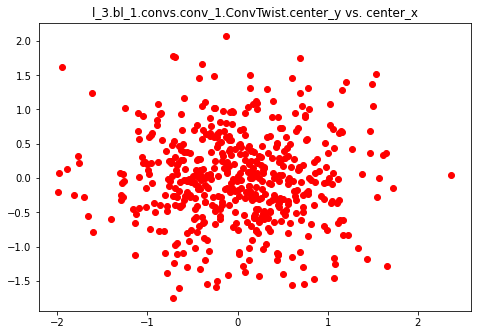

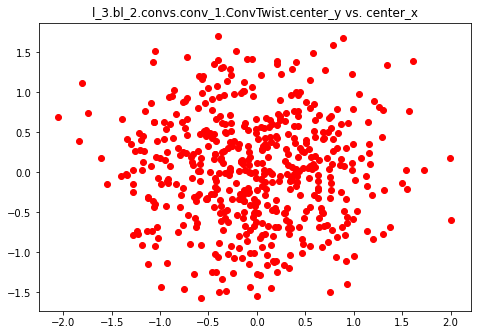

In [0]:
data = [None, None]
for name, param in learn.model.body.named_parameters():
    if 'center_x' in name:
        data[0] = param
    if 'center_y' in name:
        data[1] = param
        center_x = [x.item() for x in data[0]]
        center_y = [y.item() for y in data[1]]
        fig=plt.figure()
        ax=fig.add_axes([0,0,1,1])
        ax.scatter(center_x, center_y, color='r')
        ax.set_title(name + ' vs. center_x')
        plt.show()

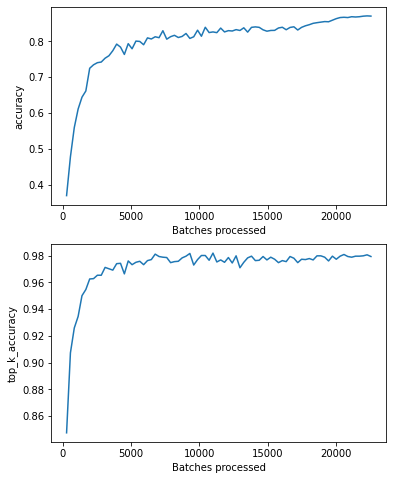

In [0]:
learn.recorder.plot_metrics()

# with iterations but no MaxBlurPool 

`iters=3`

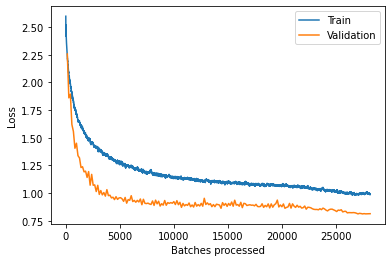

In [0]:
learn.recorder.plot_losses()

In [0]:
for i in range(200):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.2489182949066162
epoch 1 0.37210485339164734
epoch 2 0.3858488202095032
epoch 3 0.5085263252258301
epoch 4 0.5248154997825623
epoch 5 0.6133876442909241
epoch 6 0.5902265310287476
epoch 7 0.6485110521316528
epoch 8 0.6642911434173584
epoch 9 0.6945787668228149
epoch 10 0.6922881007194519
epoch 11 0.7149401903152466
epoch 12 0.7134130597114563
epoch 13 0.7353016138076782
epoch 14 0.7146856784820557
epoch 15 0.7706795334815979
epoch 16 0.7195215225219727
epoch 17 0.770425021648407
epoch 18 0.7709341049194336
epoch 19 0.7935861349105835
epoch 20 0.7729701995849609
epoch 21 0.8058030009269714
epoch 22 0.7938406467437744
epoch 23 0.8124204874038696
epoch 24 0.8058030009269714
epoch 25 0.8065665364265442
epoch 26 0.7900229096412659
epoch 27 0.8086026906967163
epoch 28 0.8040213584899902
epoch 29 0.8121659159660339
epoch 30 0.8172562718391418
epoch 31 0.8251463770866394
epoch 32 0.8170017600059509
epoch 33 0.8231102228164673
epoch 34 0.8218376040458679
epoch 35 0.8185288906097412
ep

In [0]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x -0.009412282146513462 0.724317729473114
l_0.bl_0.convs.conv_1.conv_twist.center_y -0.13338562846183777 0.7636765837669373
l_0.bl_1.convs.conv_1.conv_twist.center_x -0.003539692610502243 0.6031852960586548
l_0.bl_1.convs.conv_1.conv_twist.center_y 0.027359839528799057 0.6279412508010864
l_0.bl_2.convs.conv_1.conv_twist.center_x -0.08917878568172455 0.5440037846565247
l_0.bl_2.convs.conv_1.conv_twist.center_y -0.03030087612569332 0.5485294461250305
l_1.bl_0.convs.conv_1.conv_twist.center_x 0.028511442244052887 0.5888504385948181
l_1.bl_0.convs.conv_1.conv_twist.center_y -0.007085200399160385 0.7024179100990295
l_1.bl_1.convs.conv_1.conv_twist.center_x -0.00041383877396583557 0.617638349533081
l_1.bl_1.convs.conv_1.conv_twist.center_y 0.0271406639367342 0.6702139973640442
l_1.bl_2.convs.conv_1.conv_twist.center_x 0.00874388962984085 0.5452833771705627
l_1.bl_2.convs.conv_1.conv_twist.center_y 0.10775240510702133 0.6405677795410156
l_1.bl_3.convs.c

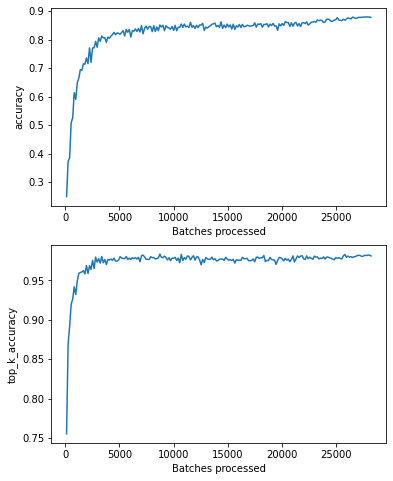

In [0]:
learn.recorder.plot_metrics()